In [15]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *


# Get Data 
---

In [16]:
prices = pd.read_csv("data/prices_data.csv", index_col=0, parse_dates=True)


In [17]:
prices

,BTC/USDT,ETH/USDT,XRP/USDT,LTC/USDT,BCH/USDT
timestamp,,,,,
2024-02-23,50744.15,2922.24,0.5342,68.80,264.7
2024-02-24,51568.22,2992.62,0.5450,70.41,267.7
2024-02-25,51728.85,3112.59,0.5425,70.16,267.9
2024-02-26,54476.47,3175.94,0.5506,71.93,274.7
2024-02-27,57037.34,3242.36,0.5861,73.97,292.8
...,...,...,...,...,...
2025-02-17,95780.00,2744.05,2.6599,122.31,323.8
2025-02-18,95671.74,2671.99,2.5628,129.75,316.3
2025-02-19,96644.37,2715.50,2.7378,134.88,322.8


# Applly funnel and test for cointegration
---

In [18]:

# Pre-filter: Calculate correlation matrix and select pairs with high correlation
corr_threshold = 0.8
corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
print(f"\nPairs with correlation >= {corr_threshold}:")
for pair in high_corr_pairs:
    print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# Cointegration test
cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)



Pairs with correlation >= 0.8:
BTC/USDT & XRP/USDT: correlation = 0.9238
BTC/USDT & LTC/USDT: correlation = 0.8630
XRP/USDT & LTC/USDT: correlation = 0.8555

Cointegrated pairs (from pre-filtered high-correlation pairs):
BTC/USDT & XRP/USDT: p-value = 0.0333, correlation = 0.9238


In [19]:
# cointegrated_pairs = [('BTC/USDT',
#   'XRP/USDT',
#   np.float64(0.033299891854170274),
#   np.float64(0.9238272627978802))]

In [20]:
analyze_residuals(residuals_df, lags = 20)

P-value for Ljung-Box test for pair BTC/USDT_XRP/USDT: 0.617448397217482
Residuals of pair BTC/USDT_XRP/USDT are likely white noise (independent).


In [21]:
cointegrated_pairs

[('BTC/USDT',
  'XRP/USDT',
  np.float64(0.033299891854170274),
  np.float64(0.9238272627978802))]

# Test strategy
---


Testing strategy on pair: BTC/USDT and XRP/USDT (p-value: 0.0333, correlation: 0.9238)
Hedge ratio (beta) for BTC/USDT ~ XRP/USDT: 16875.5486
Long Spread Trades: 5
Short Spread Trades: 3


/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


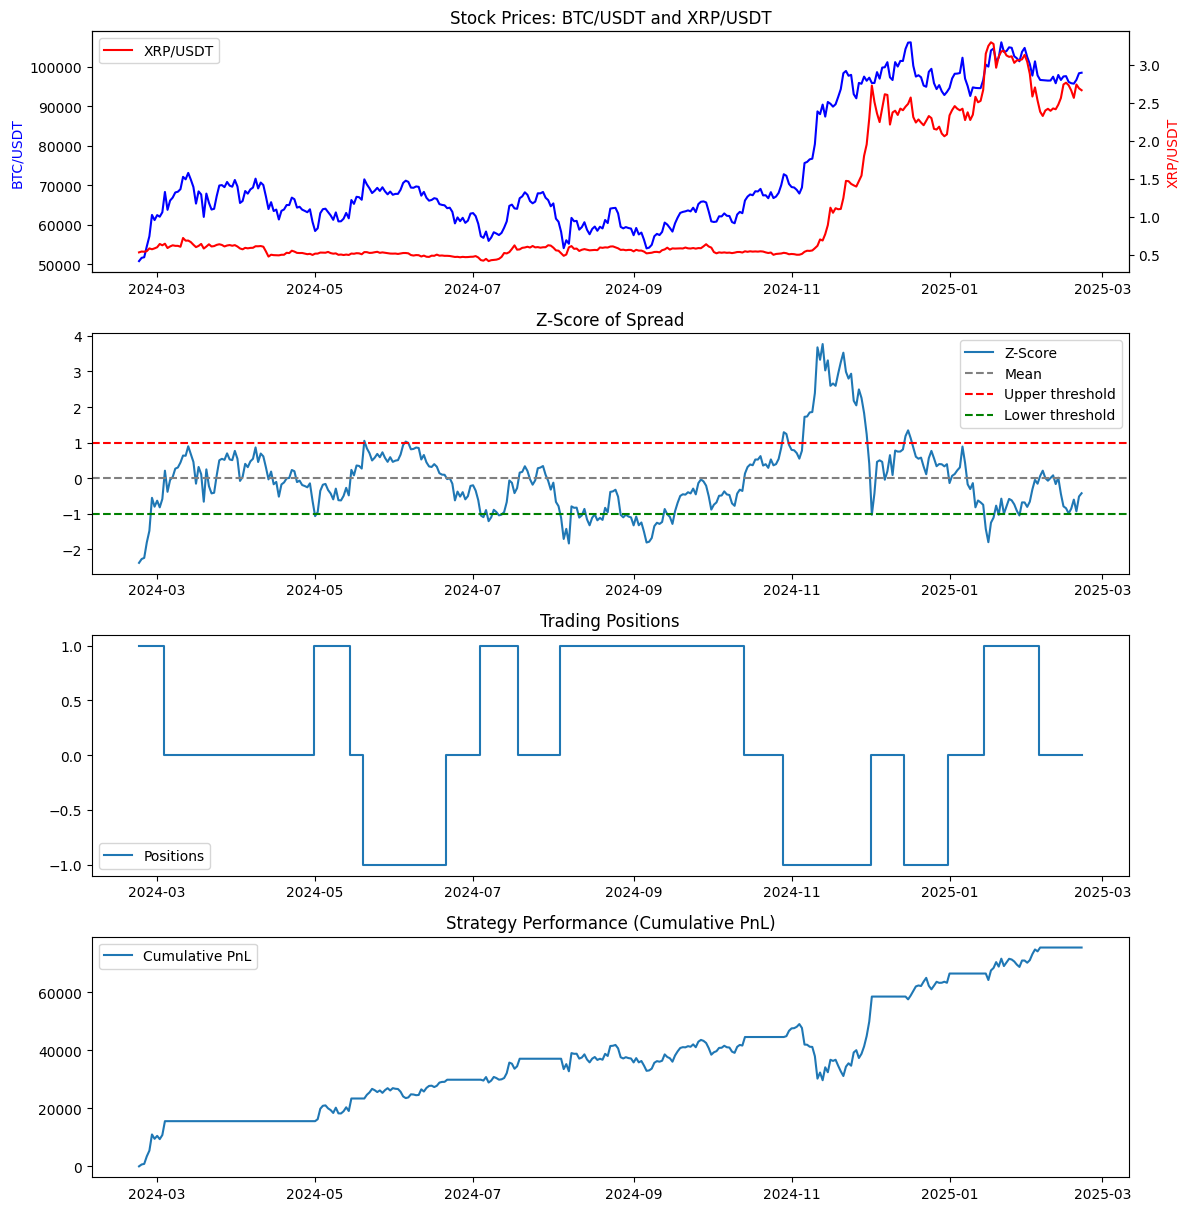

In [22]:
if cointegrated_pairs:
        sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
    
        # Compute the spread and hedge ratio
        spread, beta = compute_spread(S1, S2)
        print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
    
        # Generate trading signals based on the spread's z-score
        zscore, positions, longs, shorts = backtest_pair(spread, entry_threshold=1.0, exit_threshold=0.0)
    
        # Simulate strategy performance
        pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

        #Print number of long positions and short positions 

        print(f"Long Spread Trades: {longs}")
        print(f"Short Spread Trades: {shorts}")

        #Plot trading simulation
        plot_trading_simulation(S1, S2, sym1,sym2,zscore, positions, cum_pnl)